# Mr Haulage | Fleet Analysis | Exploratory Data Analysis
### Author: Lottie Jane Pollard

*"Data matters. Data is the way we measure progress." - Hilary Mason*

----------------------------------


<img src="/Users/lottiejanepollare/Library/Mobile Documents/com~apple~CloudDocs/CV, Profiles, Interviews & Job Applications/applications/techmodal_analyst_data_engineer/20230825_Analyst_case_study_submission_Lottie_Jane_Pollard/images/logos/techmodal/techmodal_opp_found_logo.png" alt="techmodal_logo" width="350"/>

In [1]:
# libraries to import

import pandas as pd
import math
import matplotlib.pyplot as plt
from prophet import Prophet
import seaborn as sns

### Import the clean dataset, load in the metadata, configure the display & have a look at the dataset:

In [2]:
# import the clean dataset
mr_haulage_df = pd.read_csv('/datasets/cleansed_mr_haulage_order_details.csv')

# add data types in from previous metadata
metadata_df = pd.read_excel('/datasets/metadata.xlsx')

metadata_dict = metadata_df.set_index('column_name')['datatype'].to_dict()
mr_haulage_df = mr_haulage_df.astype(metadata_dict)

# configure display settings: display all columns regardless of df width, disable wrapping columns to display entire field, no truncating columns, display an English date format
pd.set_option('display.max.columns', None, 'display.width', None, 'display.max.colwidth', None, 'display.date_dayfirst', True, 'display.float_format', '{:.2f}'.format)
# this should update the date format displayed for the whole notebook, but it isn't & I'm not sure why - maybe as I'm in Pycharm IDE note JupyterNotebooks itself

# let's see what we're working with
mr_haulage_df.head(10)

,order_id,customer_id,order_date,order_time,item_serial,box_type,delivery_region,distance_(miles),order_week,order_month,order_year,financial_quarter
0,1097342,733603,2021-08-22,00:14:00,30351,small,south_east,70,33,August,2021,Q3
1,1097343,405061,2021-08-22,07:08:00,17634,small,greater_london,32,33,August,2021,Q3
2,1097344,842139,2021-08-22,10:15:00,25598,small,south_west,190,33,August,2021,Q3
3,1097345,211806,2021-08-22,17:05:00,10104,small,south_west,85,33,August,2021,Q3
4,1097346,103222,2021-08-22,23:48:00,3252,small,greater_london,43,33,August,2021,Q3
5,1097347,603400,2021-08-22,23:57:00,62831,small,greater_london,33,33,August,2021,Q3
6,1097354,862722,2021-08-23,21:56:00,32892,small,south_wales,171,34,August,2021,Q3
7,1097353,697945,2021-08-23,20:34:00,23747,small,south_east,67,34,August,2021,Q3
8,1097352,870782,2021-08-23,19:03:00,20624,small,south_east,72,34,August,2021,Q3
9,1097350,239710,2021-08-23,11:49:00,99590,large,north_east,210,34,August,2021,Q3


In [3]:
# check metadata & datatypes have loaded correctly
mr_haulage_df.dtypes

order_id                      int64
customer_id                   int64
order_date           datetime64[ns]
order_time                   object
item_serial                   int64
box_type                   category
delivery_region            category
distance_(miles)              int64
order_week                   UInt32
order_month                  object
order_year                    int32
financial_quarter            object
dtype: object

### Let's start to inspect the relationship between the data & derive some insights:
NB: the dataset is lacking in integer types that have potential for correlation or produce a valuable heatmap, so I won't be creating on for this dataset

In [4]:
# let's declare variables for set figures now

small_box_revenue = 20
large_box_revenue = 100

small_truck_purchase_cost = 2000
large_truck_purchase_cost = 5000

### Let's look at the yearly income for orders first to get an idea of the income this contract is generating annually

In [5]:
# narrow down to one year - March 22 - March 23
one_full_year = mr_haulage_df[(mr_haulage_df['order_date'] >= '2022-03-01') & (mr_haulage_df['order_date'] <= '2023-03-31')]

# count occurrences of 'small' & 'large' in the 'box_type' column
box_counts = one_full_year['box_type'].value_counts()

# calculate income
total_yearly_income = (box_counts.get('small', 0) * small_box_revenue) + (box_counts.get('large', 0) * large_box_revenue)

print(f"March 2022 - March 2023 | No. of Small Boxes Ordered: {box_counts.get('small', 0)}")
print(f"March 2022 - March 2023 | No. of Large Boxes Ordered:  {box_counts.get('large', 0)}")
print(f"Total yearly income: £{total_yearly_income:,.2f}")

March 2022 - March 2023 | No. of Small Boxes Ordered: 1109
March 2022 - March 2023 | No. of Large Boxes Ordered:  359
Total yearly income: £58,080.00


### Let's have a look at the trend of orders over the span of the dataset:

In [6]:
# copy the dataframe
monthly_order_pattern = mr_haulage_df.copy()

# order_date as index & use resample() to aggregate data by month, so we only have one marker per month & one tick per month
monthly_order_pattern.set_index('order_date', inplace=True)
monthly_order_pattern = monthly_order_pattern.resample('M').size().reset_index(name='number_of_orders')

# format the dates for readability
monthly_order_pattern['formatted_date'] = monthly_order_pattern['order_date'].dt.strftime('%b_%y')

monthly_order_pattern

,order_date,number_of_orders,formatted_date
0,2021-08-31,65,Aug_21
1,2021-09-30,80,Sep_21
2,2021-10-31,95,Oct_21
3,2021-11-30,79,Nov_21
4,2021-12-31,58,Dec_21
5,2022-01-31,59,Jan_22
6,2022-02-28,55,Feb_22
7,2022-03-31,127,Mar_22
8,2022-04-30,107,Apr_22
9,2022-05-31,121,May_22


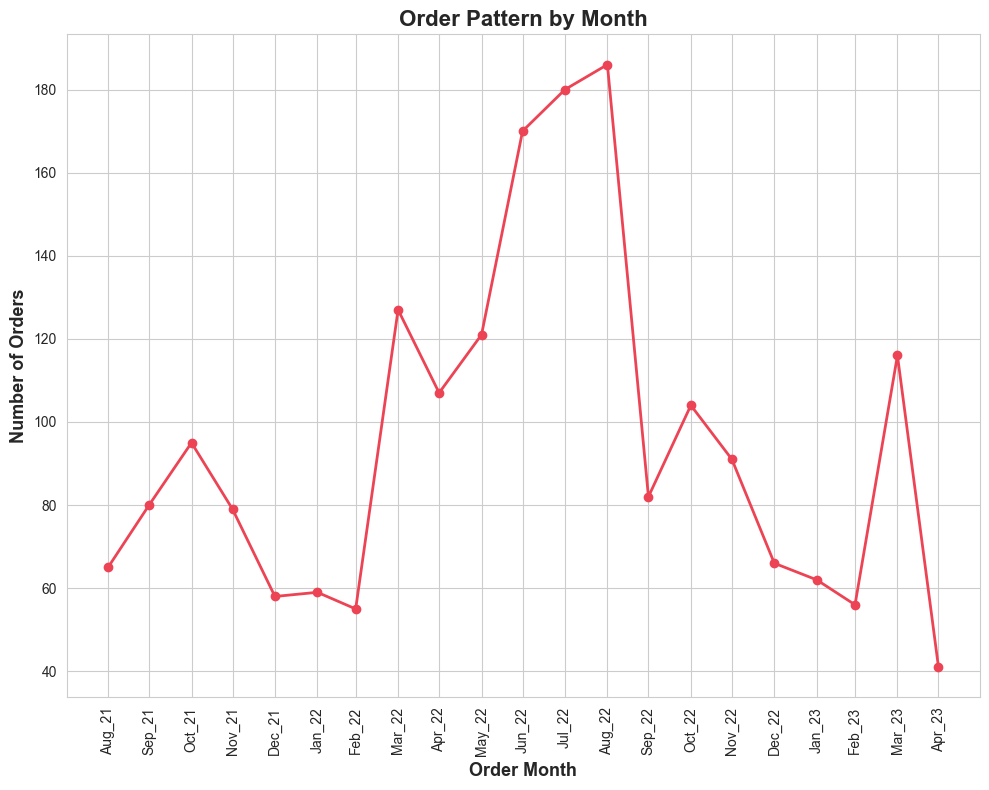

In [7]:
# let's visualise this

plt.figure(figsize=(10, 8))

plt.plot(monthly_order_pattern['order_date'], monthly_order_pattern['number_of_orders'],
         marker='o', linestyle='-', linewidth=2, color='#ED4455')

plt.grid(True)
plt.title('Order Pattern by Month', fontsize=16, fontweight='bold', ha='center', y=1.0)
plt.xlabel('Order Month', fontweight='bold', fontsize=13)
plt.ylabel('Number of Orders', fontweight='bold', fontsize=13)

plt.xticks(monthly_order_pattern['order_date'], monthly_order_pattern['formatted_date'], rotation='vertical')

plt.tight_layout()
plt.savefig('/images/data_visualisations/fig1_order_pattern_by_month.png')

plt.show()

### The plot reveals several interesting trends and patterns in the data:

* There could be some seasonality in the data. Specifically, orders tend to peak around mid-year (June to August) and dip during the end and beginning of the year but we don't have June - August 21 or 23 to confirm this. This data would be greatly impactful.

* Growth Pattern: From March 2022 to August 2022, there is a noticeable upward trend, indicating a period of significant growth in the number of orders. Could this be the peak months or was there a reason for this spike?

* After the peak in August 2022, there is a significant drop in September 2022, followed by some fluctuations. This could be indicative of some event or change that affected the number of orders.

* The lowest number of orders occurs generally around the end and the beginning of the year, specifically in December and January.

* After a dip in January and February 2023, the number of orders seems to recover in March 2023.

* Overall Increase: Despite fluctuations, if you look from August 2021 to March 2023, there is a general increase in the number of orders, indicating positive growth.

### Let's look at possible future order volumes using Facebook's open source modelling library Prophet. Prophet uses a 95% confidence interval which means that the model is 95% sure that the predictions will fall within the shaded area on the plot.

I chose to use Prophet as it's relatively easy to use, and it also takes seasonal effects into consideration, which is crucial in this business case.

21:58:13 - cmdstanpy - INFO - Chain [1] start processing
21:58:19 - cmdstanpy - INFO - Chain [1] done processing


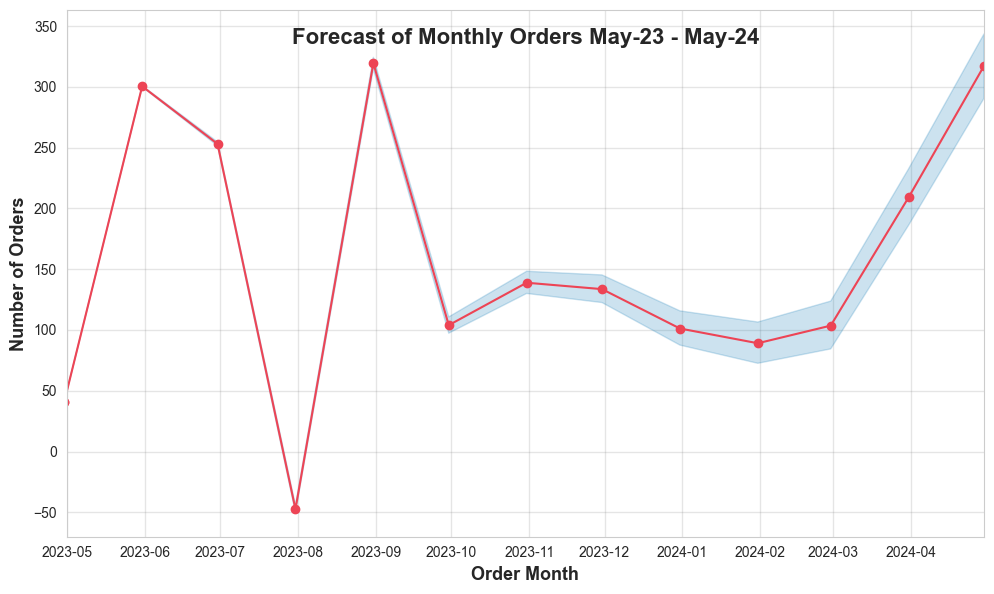

--------------------------------------------------------
Mr Haulage can see that the predicted order peak has been included in the model. Orders are expected to fall seasonally over the winter months as is usual. However, delightfully, the model has taken the general increase in order numbers & historical positive growth into consideration & can say with 95% confidence that the orders for the Oct 23 - Jan 24 will be reasonably higher than the last two years
--------------------------------------------------------
NB: If I had more time I would have overlayed the previous year on here to get actual figures of expected growth 
--------------------------------------------------------


In [44]:
# rename columns to fit the Prophet naming scheme
prophet_df = monthly_order_pattern.rename(columns={'order_date': 'ds', 'number_of_orders': 'y'})

model = Prophet(yearly_seasonality=True)
model.fit(prophet_df)

# create future dataframe over 12 months with monthly frequency
future_dates = model.make_future_dataframe(periods=12, freq='M')

# forecast the order volume
forecast = model.predict(future_dates)

# plot the forecast
fig = model.plot(forecast)

# narrow down the x axis to show a closer look
ax = fig.gca()
ax.set_xlim([pd.to_datetime('2023-05-01'), forecast['ds'].max()])

# editing colour & markers using .line
for line in ax.lines:
    line.set_color('#ED4455')
    line.set_marker('o')

ax.set_title('Forecast of Monthly Orders May-23 - May-24', fontsize=16, fontweight='bold', loc='center', y=0.92)
ax.set_xlabel('Order Month', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Orders', fontsize=13, fontweight='bold')

plt.savefig('images/data_visualisations/fig2_prophet_forecast_monthly_order_volume_may23-may24.png')

plt.show()

print(f"--------------------------------------------------------")
print(f"Mr Haulage can see that the predicted order peak has been included in the model. Orders are expected to fall seasonally over the winter months as is usual. However, delightfully, the model has taken the general increase in order numbers & historical positive growth into consideration & can say with 95% confidence that the orders for the Oct 23 - Jan 24 will be reasonably higher than the last two years")
print(f"--------------------------------------------------------")
print(f"NB: If I had more time I would have overlayed the previous year on here to get actual figures of expected growth ")
print(f"--------------------------------------------------------")

### Let's look at the 'distance_(miles)' for each delivery in relation to the 'delivery_region', this will give me an idea of where the main distribution depot is. I can also then use this to look at it in relation to the percentage of order placed in each region:

In [9]:
# calculate the delivery distance per delivery region
avg_distance_per_region = mr_haulage_df.copy().groupby('delivery_region')['distance_(miles)'].mean().reset_index().sort_values(by='distance_(miles)')

print(f"--------------------------------------------------------")
print(f"The main distribution depot is most likely to be in {avg_distance_per_region['delivery_region'].iloc[0]} as it's the shortest delivery distance")
print(f"--------------------------------------------------------")
avg_distance_per_region

--------------------------------------------------------
The main distribution depot is most likely to be in greater_london as it's the shortest delivery distance
--------------------------------------------------------


,delivery_region,distance_(miles)
1,greater_london,26.91
4,south_east,60.23
0,east_midlands,82.70
7,west_midlands,119.23
6,south_west,179.88
5,south_wales,195.53
3,north_wales,213.87
2,north_east,233.84


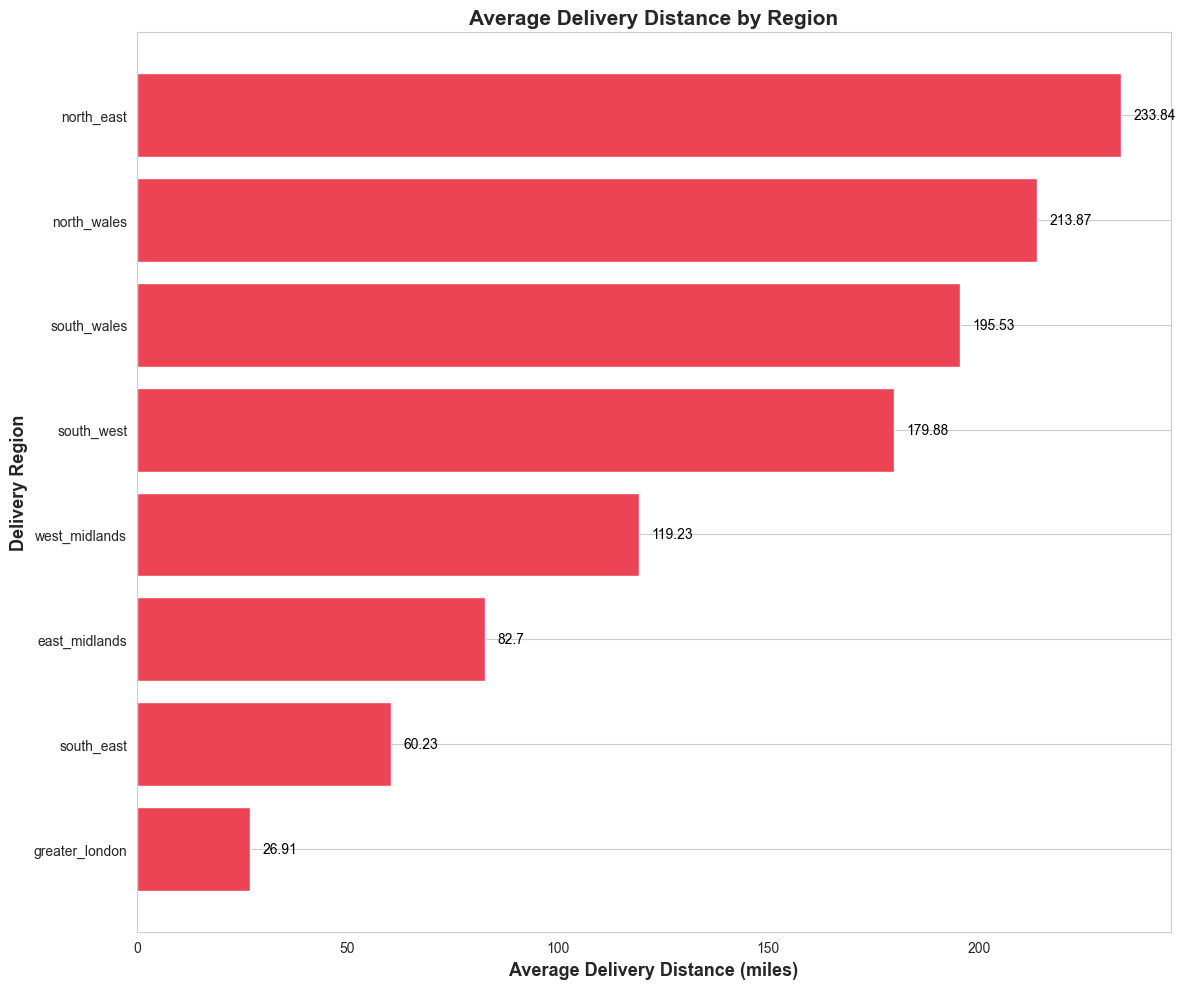

--------------------------------------------------------
OBSERVATIONS: We can see that the shortest distance a courier has to travel from it's starting position is an average of 26.91 miles within Greater London
--------------------------------------------------------


In [10]:
# let's see this as a visualisation

plt.figure(figsize=(12, 10))

plt.barh(avg_distance_per_region['delivery_region'], avg_distance_per_region['distance_(miles)'], color='#ED4455')

plt.title('Average Delivery Distance by Region', fontweight='bold', fontsize=15, loc='center', y=1.0)
plt.xlabel('Average Delivery Distance (miles)', fontweight='bold', fontsize=13)
plt.ylabel('Delivery Region', fontweight='bold', fontsize=13)

# annotate each bar with values
for i, v in enumerate(avg_distance_per_region['distance_(miles)']):
    plt.text(v + 3, i, str(round(v, 2)), va='center', color='black')

plt.grid(axis='x')
plt.tight_layout()
plt.savefig('/images/data_visualisations/fig3_avg_delivery_distance_by_region.png')

plt.show()

print(f"--------------------------------------------------------")
print(f"OBSERVATIONS: We can see that the shortest distance a courier has to travel from it's starting position is an average of 26.91 miles within Greater London")
print(f"--------------------------------------------------------")

### Let's look at the most popular delivery regions:

In [11]:
# count ('order_count') & sort the delivery regions
most_popular_delivery_regions_by_orders = mr_haulage_df.copy().groupby('delivery_region').size().reset_index(name='order_count').sort_values('order_count', ascending=False)

# calculate the total number of orders
total_orders = most_popular_delivery_regions_by_orders['order_count'].sum()

# calculate percentage of orders
most_popular_delivery_regions_by_orders['percentage_of_total_orders'] = (most_popular_delivery_regions_by_orders['order_count'] / total_orders) * 100

most_popular_delivery_regions_by_orders

,delivery_region,order_count,percentage_of_total_orders
1,greater_london,629,31.45
4,south_east,475,23.75
6,south_west,309,15.45
0,east_midlands,199,9.95
5,south_wales,132,6.60
2,north_east,108,5.40
7,west_midlands,96,4.80
3,north_wales,52,2.60


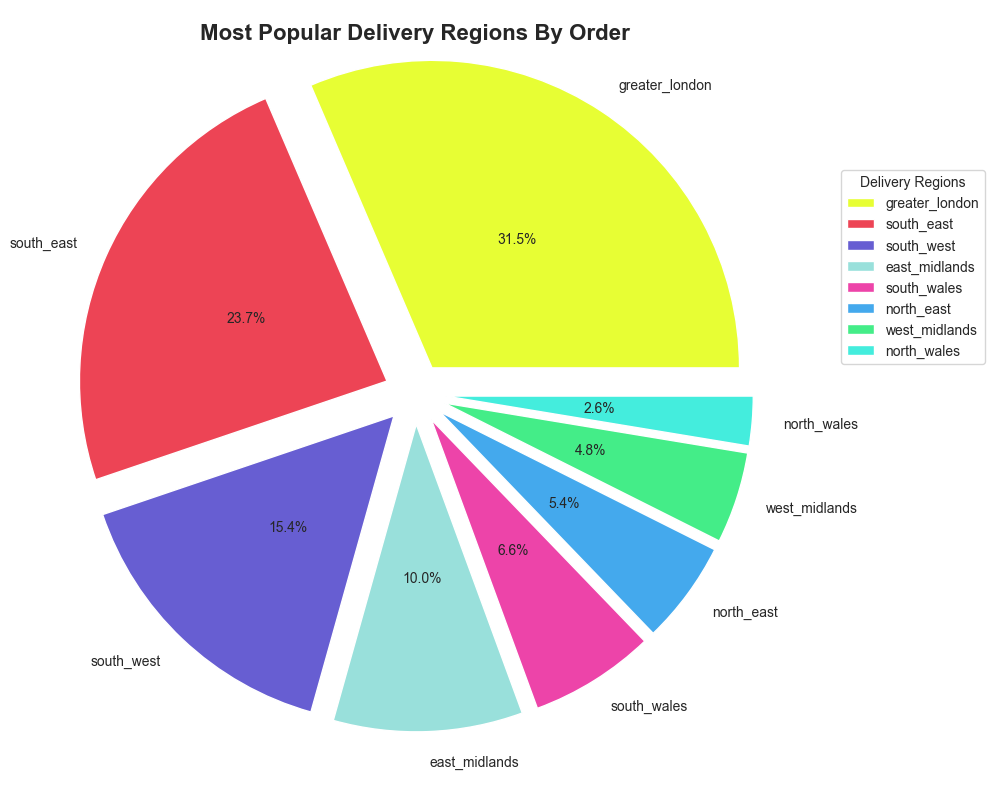

--------------------------------------------------------
OBSERVATONS: We can see that the most popular delivery region is Greater London with 31.5% of orders being delivered here
--------------------------------------------------------


In [12]:
# let's see this as a visualisation

plt.figure(figsize=(10, 10))

# choose favourite colours
colours = ['#E7FE34', '#ED4455', '#675ED2', '#99E0DB', '#ED44A9', '#44A9ED', '#44ED88', '#44EDDD']

plt.pie(most_popular_delivery_regions_by_orders['percentage_of_total_orders'], labels=most_popular_delivery_regions_by_orders['delivery_region'], colors=colours, autopct='%1.1f%%', pctdistance=0.5,
        explode=[0.1]*len(most_popular_delivery_regions_by_orders))

plt.title('Most Popular Delivery Regions By Order', fontsize=16, fontweight='bold', ha='center', y=0.95)
plt.legend(title='Delivery Regions', loc='upper right', bbox_to_anchor=(1.25, 0.8))

plt.tight_layout()
plt.savefig('/images/data_visualisations/fig4_most_popular_delivery_regions_by_order.png')

plt.show()

print(f"--------------------------------------------------------")
print(f"OBSERVATONS: We can see that the most popular delivery region is Greater London with 31.5% of orders being delivered here")
print(f"--------------------------------------------------------")

### Okay, let's overlay these two visuals to see the correlation between the region with the shortest delivery distance & the most common delivery region:

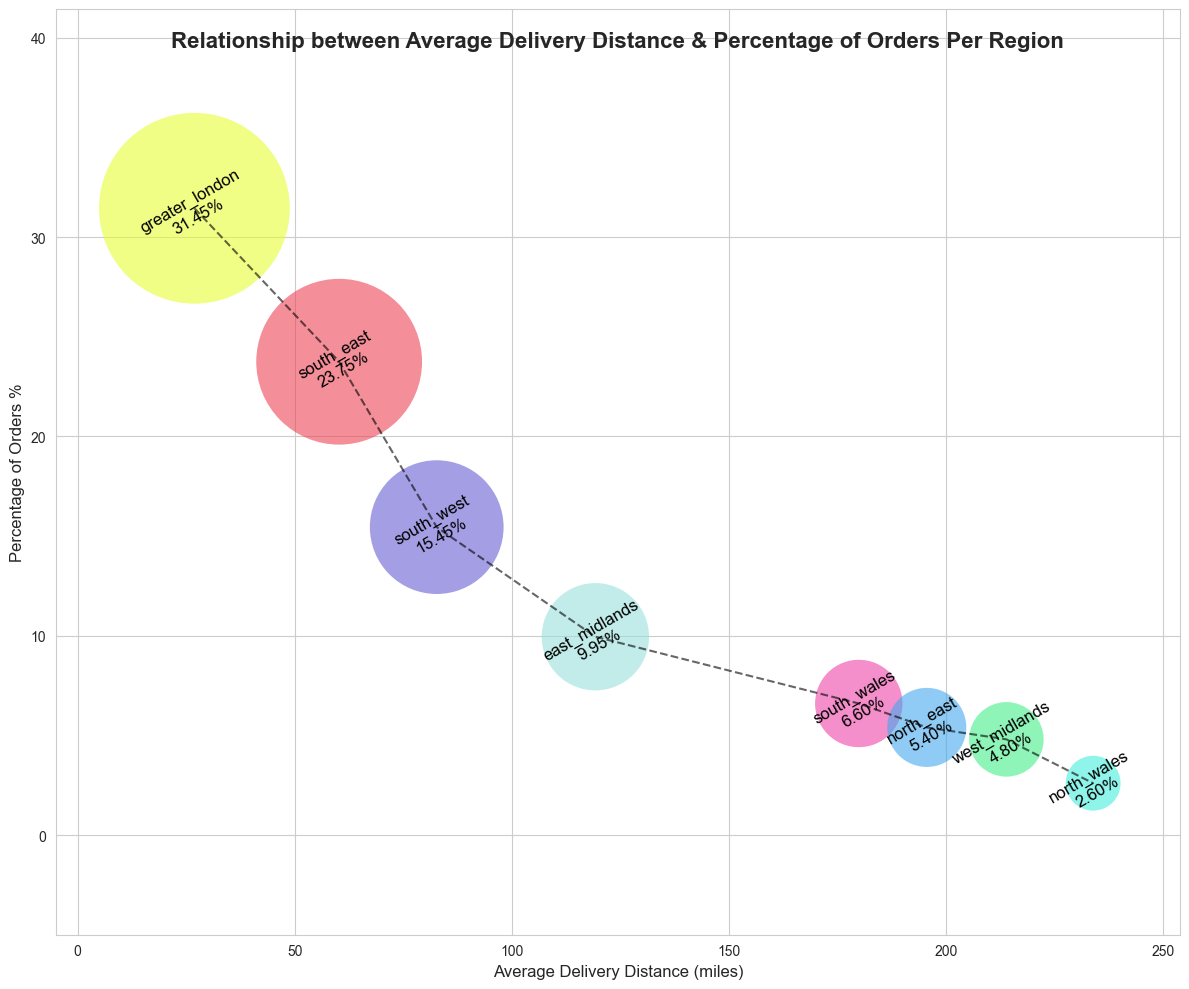

--------------------------------------------------------
OBSERVATIONS: Here we can see that there is a negative correlation between the percentage of orders and the distance travelled to fulfil the order, which indicates that the further away the delivery the less orders we have, conversely, the shorter the distance travelled, the more orders we have.
--------------------------------------------------------


In [13]:
# let's visualise this
fig, ax = plt.subplots(figsize=(12, 10))

# create bubble chart
scatter = ax.scatter(avg_distance_per_region['distance_(miles)'], most_popular_delivery_regions_by_orders['percentage_of_total_orders'],
                     s=most_popular_delivery_regions_by_orders['percentage_of_total_orders'] * 600,
                     c=colours, alpha=0.6, edgecolors='none', marker='o')

# annotate each bubble
for i, (index, row) in enumerate(most_popular_delivery_regions_by_orders.iterrows()):
    text_label = f"{row['delivery_region']}\n{row['percentage_of_total_orders']:.2f}%"
    plt.text(avg_distance_per_region['distance_(miles)'].iloc[i], row['percentage_of_total_orders'],
             text_label, color='black', ha='center', va='center', fontsize=12, rotation=30)

# connect bubbles
plt.plot(avg_distance_per_region['distance_(miles)'], most_popular_delivery_regions_by_orders['percentage_of_total_orders'], linestyle='--', color='black', alpha=0.6)

# increase axis range to avoid cutting off the bubbles or text
plt.ylim(-5, max(most_popular_delivery_regions_by_orders['percentage_of_total_orders']) + 10)
plt.xlim(-5, max(avg_distance_per_region['distance_(miles)']) + 20)

plt.grid(True)
plt.title('Relationship between Average Delivery Distance & Percentage of Orders Per Region', fontsize=16, fontweight='bold', ha='center', y=0.95)
plt.xlabel('Average Delivery Distance (miles)', fontsize=12)
plt.ylabel('Percentage of Orders %', fontsize=12)

plt.tight_layout()

plt.savefig('/images/data_visualisations/fig5_relationship_between_avg_delivery_distance_and_percentage_orders_per_region.png')

plt.show()

print(f"--------------------------------------------------------")
print(f"OBSERVATIONS: Here we can see that there is a negative correlation between the percentage of orders and the distance travelled to fulfil the order, which indicates that the further away the delivery the less orders we have, conversely, the shorter the distance travelled, the more orders we have.")
print(f"--------------------------------------------------------")

### Let's look at the most popular customer_id's:

In [14]:
# number of unique customers
number_of_unique_customers = mr_haulage_df['customer_id'].copy().nunique()

# orders per customer
orders_per_customer = mr_haulage_df.groupby('customer_id').size().reset_index(name='number_of_orders').sort_values(by='number_of_orders', ascending=False)

# repeat customers
repeat_customers = orders_per_customer[orders_per_customer['number_of_orders'] > 1]

print(f"We have {number_of_unique_customers} unique customers.")
print(f"--------------------------------------------------------")
print(f"Of our {number_of_unique_customers} customers, only {len(repeat_customers)} of them are repeat customers.")
print(f"--------------------------------------------------------")

orders_per_customer.head(len(repeat_customers))

# calculate percentage of repeat customers
percentage_repeat_customers = (len(repeat_customers) / number_of_unique_customers) * 100

print(f"The percentage of repeat customers is: {percentage_repeat_customers:.2f}%.")
print(f"--------------------------------------------------------")


We have 1792 unique customers.
--------------------------------------------------------
Of our 1792 customers, only 4 of them are repeat customers.
--------------------------------------------------------
The percentage of repeat customers is: 0.22%.
--------------------------------------------------------


### OBSERVATIONS:
- This indicates that only 4 of our 1,792 customers have placed more than one order, 0.22% to be precise; again highlighting my concern to confirm that they are all part of the same Defence contract.

In [15]:
# get customer_id's of the first 4 customers
top_4_repeat_customers = repeat_customers['customer_id'].head(4).values

# filter dataframe on those customer_id's
filtered_df = mr_haulage_df[mr_haulage_df['customer_id'].isin(top_4_repeat_customers)]

# loop to find the most common delivery region for each of the repeat customers
for customer_id in top_4_repeat_customers:
    most_common_region = filtered_df[filtered_df['customer_id'] == customer_id]['delivery_region'].value_counts().idxmax()
    print(f"The most common delivery region for customer ID {customer_id} is {most_common_region}.")
    print(f"--------------------------------------------------------")


The most common delivery region for customer ID 103222 is greater_london.
--------------------------------------------------------
The most common delivery region for customer ID 104011 is greater_london.
--------------------------------------------------------
The most common delivery region for customer ID 100131 is greater_london.
--------------------------------------------------------
The most common delivery region for customer ID 246796 is south_east.
--------------------------------------------------------


### OBSERVATIONS:

- The 4 repeat customers are all located in the top 2 closest delivery regions: 75% in Greater London & 25% in the South East.

In [16]:
# let's look at the most popular delivery regions by total customers
most_popular_delivery_regions_by_customers = mr_haulage_df.copy().groupby('delivery_region')['customer_id'].nunique().reset_index(name='unique_customer_count').sort_values('unique_customer_count', ascending=False)

# calculate the total number of customers
total_customers = most_popular_delivery_regions_by_customers['unique_customer_count'].sum()

# add a column for percentage of total customers
most_popular_delivery_regions_by_customers['percentage_of_total_customers'] = (most_popular_delivery_regions_by_customers['unique_customer_count'] / total_customers) * 100

most_popular_delivery_regions_by_customers

,delivery_region,unique_customer_count,percentage_of_total_customers
1,greater_london,563,31.05
4,south_east,436,24.05
6,south_west,276,15.22
0,east_midlands,171,9.43
5,south_wales,124,6.84
2,north_east,102,5.63
7,west_midlands,91,5.02
3,north_wales,50,2.76


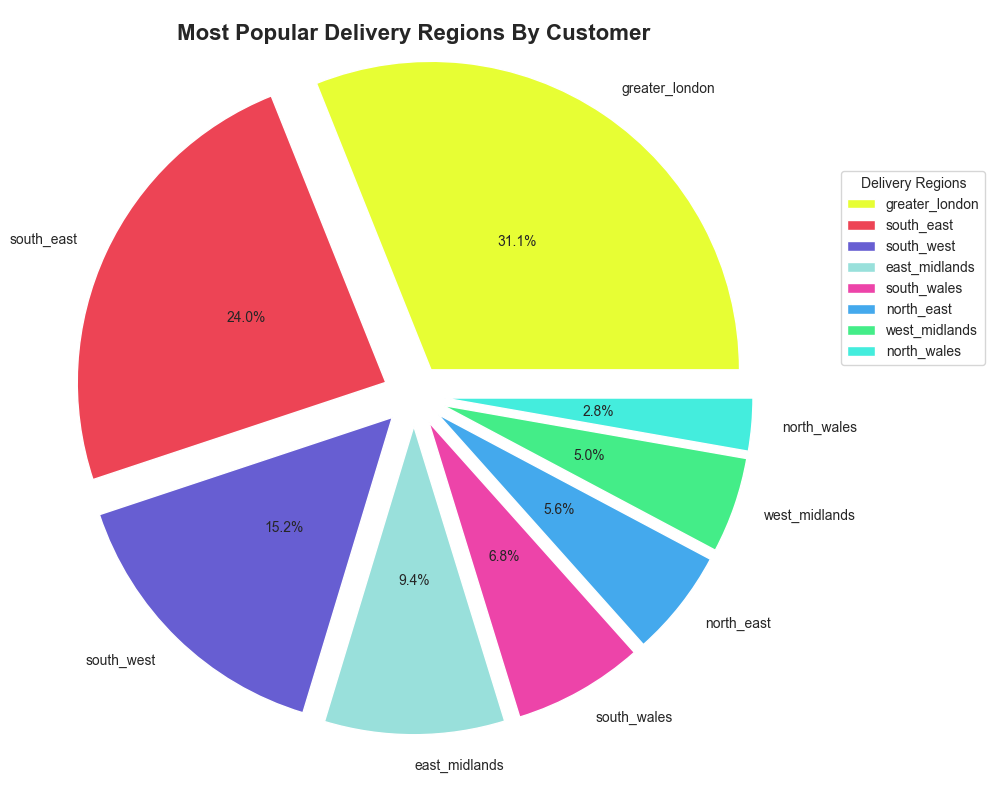

--------------------------------------------------------
OBSERVATIONS: Here we can see that the most popular delivery region by customer is Greater London with 31.5% of orders being delivered here. Similar to most popular region by order, this gives reinforced reassurance in making business decisions related to fleet, drivers, new depots.
--------------------------------------------------------


In [17]:
# let's see this as a visualisation

plt.figure(figsize=(10, 10))

# choose favourite colours
colours = ['#E7FE34', '#ED4455', '#675ED2', '#99E0DB', '#ED44A9', '#44A9ED', '#44ED88', '#44EDDD']

plt.pie(most_popular_delivery_regions_by_customers['percentage_of_total_customers'], labels=most_popular_delivery_regions_by_customers['delivery_region'], colors=colours, autopct='%1.1f%%', pctdistance=0.5,
        explode=[0.1]*len(most_popular_delivery_regions_by_customers))

plt.title('Most Popular Delivery Regions By Customer', fontsize=16, fontweight='bold', ha='center', y=0.95)
plt.legend(title='Delivery Regions', loc='upper right', bbox_to_anchor=(1.25, 0.8))

plt.tight_layout()
plt.savefig('/images/data_visualisations/fig6_most_popular_delivery_regions_by_customer.png')

plt.show()

print(f"--------------------------------------------------------")
print(f"OBSERVATIONS: Here we can see that the most popular delivery region by customer is Greater London with 31.5% of orders being delivered here. Similar to most popular region by order, this gives reinforced reassurance in making business decisions related to fleet, drivers, new depots.")
print(f"--------------------------------------------------------")

## SOLVING THE PROBLEM:
### Let's look at how to figure out how many trucks Mr. Haulage may need...

- First, let's aggregate the historical boxes ordered each day
- Then, let's only take the most recent data for a full year - which would be March 2022 - March 2023 - This would be the most reliable data to base our decision on

In [18]:
# filter the data to only include the records from 2022-03-01 to 2023-03-31
latest_full_year_data = mr_haulage_df[(mr_haulage_df['order_date'] >= '2022-03-01') & (mr_haulage_df['order_date'] <= '2023-03-31')]

# first, let's look at the historical daily demand for each box size per region
estimated_daily_demand = latest_full_year_data.groupby(['order_date', 'delivery_region', 'box_type']).size().reset_index(name='box_count')

# Filter out rows where count is 0
estimated_daily_demand = estimated_daily_demand[estimated_daily_demand['box_count'] > 0]

estimated_daily_demand

,order_date,delivery_region,box_type,box_count
2,2022-03-01,greater_london,large,1
9,2022-03-01,south_east,small,1
11,2022-03-01,south_wales,small,1
12,2022-03-01,south_west,large,1
13,2022-03-01,south_west,small,1
...,...,...,...,...
6297,2023-03-29,south_east,small,1
6307,2023-03-30,greater_london,small,2
6312,2023-03-30,south_east,large,1
6333,2023-03-31,south_west,small,1


### Now we have our estimated daily demand based on the last years worth of orders, we can perform some checks to see how we can determine the number of trucks we may need to buy to replace the current fleet

# OPTION 1 | PRIORITISING LARGE TRUCKS TO ALLOW FOR GROWTH
By opting to purchase large trucks instead of small (in cases where you have surplus 1,2,3 small boxes - not enough to fill a large truck) you are allowing for growth of an extra small box & giving yourself the flexibility to utilise the same vehicle for large or small boxes)

### Let's create a dataframe showing how many trucks are needed for the number of boxes on each day:

In [19]:
# let's copy the estimated daily demand to calculate OPTION 1
daily_demand_op_1 = estimated_daily_demand.copy()

In [20]:
# initialise an list to store aggregated records
aggregated_data_daily_op_1 = []

# loop through each unique combination of delivery_region & order_date
for (region, date) in daily_demand_op_1.groupby(['delivery_region', 'order_date']).groups.keys():
    region_date_data_op_1 = daily_demand_op_1[(daily_demand_op_1['delivery_region'] == region) & (daily_demand_op_1['order_date'] == date)]

    # initialise counters for trucks
    daily_small_trucks_op_1 = 0
    daily_large_trucks_op_1 = 0

    # calculate number of small trucks
    if 'small' in region_date_data_op_1['box_type'].values:
        daily_small_box_count_op_1 = region_date_data_op_1.loc[region_date_data_op_1['box_type'] == 'small', 'box_count'].values[0]

        # convert sets of 4 small boxes to a large truck
        daily_large_trucks_op_1 += daily_small_box_count_op_1 // 4
        remaining_small_boxes_op_1 = daily_small_box_count_op_1 % 4

        # if there are 3 remaining small boxes, use a large truck
        if remaining_small_boxes_op_1 == 3:
            daily_large_trucks_op_1 += 1
        # if there are 2 remaining small boxes, use two small trucks
        if remaining_small_boxes_op_1 == 2:
            daily_small_trucks_op_1 += 2
        # if there is 1 remaining small box, use a small truck
        elif remaining_small_boxes_op_1 == 1:
            daily_small_trucks_op_1 += 1

    # calculate number of large trucks
    if 'large' in region_date_data_op_1['box_type'].values:
        daily_large_box_count_op_1 = region_date_data_op_1.loc[region_date_data_op_1['box_type'] == 'large', 'box_count'].values[0]
        daily_large_trucks_op_1 += daily_large_box_count_op_1

    # append to initialised list
    aggregated_data_daily_op_1.append([date, region, daily_small_trucks_op_1, daily_large_trucks_op_1])

# convert list to dataframe
aggregated_df_daily_op_1 = pd.DataFrame(aggregated_data_daily_op_1, columns=['order_date', 'delivery_region', 'daily_small_trucks_needed', 'daily_large_trucks_needed']).sort_values(by='order_date', ascending=True)

aggregated_df_daily_op_1

,order_date,delivery_region,daily_small_trucks_needed,daily_large_trucks_needed
837,2022-03-01,south_west,1,1
493,2022-03-01,south_east,1,0
742,2022-03-01,south_wales,1,0
122,2022-03-01,greater_london,0,1
1004,2022-03-01,west_midlands,1,0
...,...,...,...,...
121,2023-03-29,east_midlands,1,0
741,2023-03-30,south_east,0,1
393,2023-03-30,greater_london,2,0
1003,2023-03-31,south_west,1,0


In [21]:
# let's group by date and aggregate the count of trucks
groupby_date_agg_trucks_op_1 = aggregated_df_daily_op_1.groupby('order_date').agg({
    'daily_small_trucks_needed': 'sum',
    'daily_large_trucks_needed': 'sum'
}).reset_index()

groupby_date_agg_trucks_op_1

,order_date,daily_small_trucks_needed,daily_large_trucks_needed
0,2022-03-01,4,2
1,2022-03-02,3,1
2,2022-03-03,3,1
3,2022-03-04,4,1
4,2022-03-05,2,2
...,...,...,...
391,2023-03-27,1,1
392,2023-03-28,4,0
393,2023-03-29,2,0
394,2023-03-30,2,1


In [22]:
# now, to see the maximum, we'd need to service the contract efficiently
max_small_trucks_op_1 = groupby_date_agg_trucks_op_1['daily_small_trucks_needed'].max()
max_large_trucks_op_1 = groupby_date_agg_trucks_op_1['daily_large_trucks_needed'].max()

cost_of_fleet_expenditure_op_1 = (max_large_trucks_op_1 * large_truck_purchase_cost) + (max_small_trucks_op_1 * small_truck_purchase_cost)

print(f"The total number of Small Trucks to purchase based on the historical dataset provided is: {max_small_trucks_op_1}.")
print(f"--------------------------------------------------------")
print(f"The total number of Large Trucks to purchase based on the historical dataset provided is: {max_large_trucks_op_1}.")
print(f"--------------------------------------------------------")
print(f"The total expenditure to purchase this sized fleet would be : £{cost_of_fleet_expenditure_op_1:,.2f}.")
print(f"--------------------------------------------------------")
print(f"£{cost_of_fleet_expenditure_op_1:,.2f} is {cost_of_fleet_expenditure_op_1 / total_yearly_income * 100:,.2f}% of the yearly income.")
print(f"--------------------------------------------------------")

The total number of Small Trucks to purchase based on the historical dataset provided is: 8.
--------------------------------------------------------
The total number of Large Trucks to purchase based on the historical dataset provided is: 5.
--------------------------------------------------------
The total expenditure to purchase this sized fleet would be : £41,000.00.
--------------------------------------------------------
£41,000.00 is 70.59% of the yearly income.
--------------------------------------------------------


### OBSERVATIONS:
- Let's look for outliers in this data that could be skewing the results

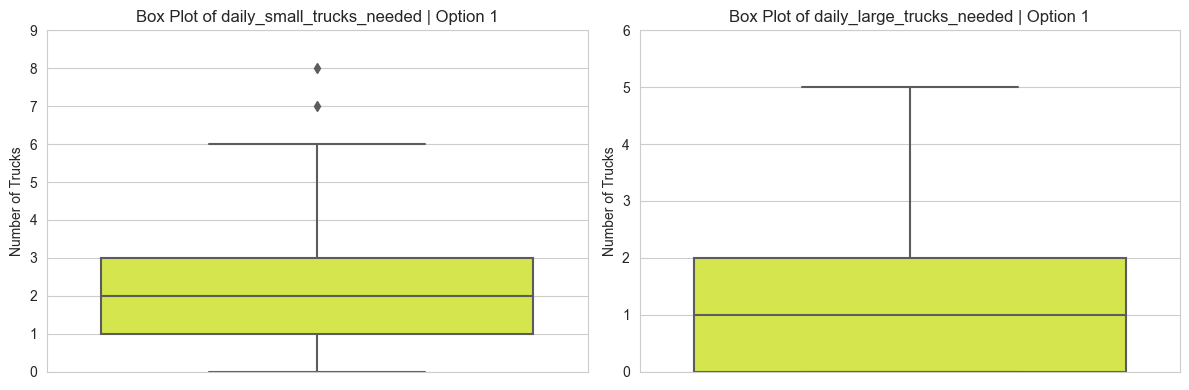

In [23]:
# let's visualise the outliers for Option 1

# columns to plot
columns_to_plot = ['daily_small_trucks_needed', 'daily_large_trucks_needed']

# figure & a grid of subplots
fig, axes = plt.subplots(1, len(columns_to_plot), figsize=(12, 4))

# loop to create individual box plots for each column next to each other
for i, column in enumerate(columns_to_plot):
    sns.boxplot(y=groupby_date_agg_trucks_op_1[column], ax=axes[i], color='#E7FE34')
    axes[i].set_title(f'Box Plot of {column} | Option 1')
    axes[i].set_ylabel('Number of Trucks')

    # set y-limits for a closer scale
    axes[i].set_ylim(min(groupby_date_agg_trucks_op_1[column]), max(groupby_date_agg_trucks_op_1[column]) + 1)

plt.savefig('/images/data_visualisations/fig7_boxplots_option1.png')

plt.tight_layout()

plt.show()


## OPTION 1 | BOX PLOT OBSERVATIONS:

**Small Trucks:**

- Interquartile Range & Median: IQR is 1 - 3 with a median of 2 small trucks
- Whiskers / Tail - Slightly right skewed distribution of the data. This suggests that a greater number of data points fall below the mean (average) than above it, indicating that on most days Mr. Haulage will need fewer small trucks.
- Outliers - We have clear outliers in Option 1: 7 & 8 small trucks are not the norm & can be excluded from the daily demand.

**Large Trucks:**

- Interquartile Range & Median: IQR is 0 - 2, and the median is 1. This implies that on most days, you would need between 0 & 2 large trucks, with a typical day requiring just 1 large truck.
- Whiskers / Tail - The absence of a left whisker indicates that the lower values (around 0) are so common that they are not considered outliers or extremes. This suggests that there are many days when no large trucks are needed at all. The right whisker extending from 2 - 5 indicates that there are days when more than 2 large trucks may be needed, up to a maximum of 5.
- Outliers - The absence of outliers indicates that the requirement for large trucks is fairly consistent, with no extreme values that deviate significantly from the rest of the data.

**CONCLUSION:**

- Mr. Haulage can consider maintaining a base fleet of 3-5 trucks—comprising 2-3 small trucks and 1-2 large trucks—to cover the majority of operational needs. The typical day would likely require 2 small trucks and 1 large truck, making this a cost-efficient base fleet. Given the slight right skew in the demand for small trucks and the occasional need for up to 5 large trucks, a contingency plan involving rented trucks for peak days would add flexibility and further cost efficiency. The absence of outliers in large truck requirements indicates a more predictable demand, simplifying planning. Overall, a hybrid ownership-rental model could provide Mr. Haulage with the most balanced and cost-effective strategy for servicing the Defence contract under Option 1.


# OPTION 2 | PRIORITISING SMALL TRUCKS TO MINIMISE CAPITAL EXPENDITURE
Changing the function to increment small trucks more over large trucks (3 small boxes = 3 small trucks) only opting to increment by large truck when capacity (4 small boxes) is reached

In [24]:
# let's copy the estimated daily demand to calculate OPTION 2
daily_demand_op_2 = estimated_daily_demand.copy()

In [25]:
# initialise list to store aggregated records
aggregated_data_daily_op_2 = []

# loop through each unique combination of delivery_region & order_date
for (region, date) in daily_demand_op_2.groupby(['delivery_region', 'order_date']).groups.keys():
    region_date_data_op_2 = daily_demand_op_2[(daily_demand_op_2['delivery_region'] == region) & (daily_demand_op_2['order_date'] == date)]

    # initialise counter
    daily_small_trucks_op_2 = 0
    daily_large_trucks_op_2 = 0

    # calculate number of small trucks
    if 'small' in region_date_data_op_2['box_type'].values:
        daily_small_box_count_op_2 = region_date_data_op_2.loc[region_date_data_op_2['box_type'] == 'small', 'box_count'].values[0]

        # convert sets of 4 small boxes to a large truck
        daily_large_trucks_op_2 += daily_small_box_count_op_2 // 4
        remaining_small_boxes_op_2 = daily_small_box_count_op_2 % 4

        # if there are 1, 2, or 3 remaining small boxes, increment small trucks by that number
        if remaining_small_boxes_op_2 in [1, 2, 3]:
            daily_small_trucks_op_2 += remaining_small_boxes_op_2

    # calculate the number of large trucks
    if 'large' in region_date_data_op_2['box_type'].values:
        daily_large_box_count_op_2 = region_date_data_op_2.loc[region_date_data_op_2['box_type'] == 'large', 'box_count'].values[0]
        daily_large_trucks_op_2 += daily_large_box_count_op_2

    # append to initialised list
    aggregated_data_daily_op_2.append([date, region, daily_small_trucks_op_2, daily_large_trucks_op_2])

# convert list to dataframe
aggregated_df_daily_op_2 = pd.DataFrame(aggregated_data_daily_op_2, columns=['order_date', 'delivery_region', 'daily_small_trucks_needed', 'daily_large_trucks_needed']).sort_values(by='order_date', ascending=True)

aggregated_df_daily_op_2

,order_date,delivery_region,daily_small_trucks_needed,daily_large_trucks_needed
837,2022-03-01,south_west,1,1
493,2022-03-01,south_east,1,0
742,2022-03-01,south_wales,1,0
122,2022-03-01,greater_london,0,1
1004,2022-03-01,west_midlands,1,0
...,...,...,...,...
121,2023-03-29,east_midlands,1,0
741,2023-03-30,south_east,0,1
393,2023-03-30,greater_london,2,0
1003,2023-03-31,south_west,1,0


In [26]:
# let's group by date and aggregate the count of trucks
groupby_date_agg_trucks_op_2 = aggregated_df_daily_op_2.groupby('order_date').agg({
    'daily_small_trucks_needed': 'sum',
    'daily_large_trucks_needed': 'sum'
}).reset_index()

groupby_date_agg_trucks_op_2

,order_date,daily_small_trucks_needed,daily_large_trucks_needed
0,2022-03-01,4,2
1,2022-03-02,3,1
2,2022-03-03,3,1
3,2022-03-04,4,1
4,2022-03-05,2,2
...,...,...,...
391,2023-03-27,1,1
392,2023-03-28,4,0
393,2023-03-29,2,0
394,2023-03-30,2,1


In [27]:
# now, to see the maximum, we'd need to service the contract efficiently
max_small_trucks_op_2 = groupby_date_agg_trucks_op_2['daily_small_trucks_needed'].max()
max_large_trucks_op_2 = groupby_date_agg_trucks_op_2['daily_large_trucks_needed'].max()

cost_of_fleet_expenditure_op_2 = (max_large_trucks_op_2 * large_truck_purchase_cost) + (max_small_trucks_op_2 * small_truck_purchase_cost)

print(f"The total number of Small Trucks to purchase based on the historical dataset provided is: {max_small_trucks_op_2}.")
print(f"--------------------------------------------------------")
print(f"The total number of Large Trucks to purchase based on the historical dataset provided is: {max_large_trucks_op_2}.")
print(f"--------------------------------------------------------")
print(f"The total expenditure to purchase this sized fleet would be : £{cost_of_fleet_expenditure_op_2:,.2f}.")
print(f"--------------------------------------------------------")
print(f"£{cost_of_fleet_expenditure_op_2:,.2f} is {cost_of_fleet_expenditure_op_2 / total_yearly_income * 100:,.2f}% of the yearly income.")
print(f"--------------------------------------------------------")

The total number of Small Trucks to purchase based on the historical dataset provided is: 8.
--------------------------------------------------------
The total number of Large Trucks to purchase based on the historical dataset provided is: 5.
--------------------------------------------------------
The total expenditure to purchase this sized fleet would be : £41,000.00.
--------------------------------------------------------
£41,000.00 is 70.59% of the yearly income.
--------------------------------------------------------


### OBSERVATIONS:
- Let's look for outliers in this data that could be skewing the results

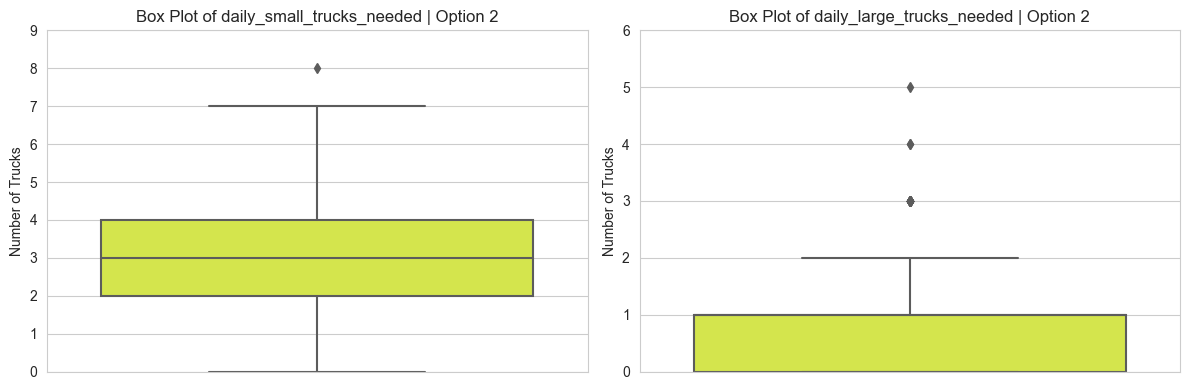

In [28]:
# let's visualise the outliers for Option 2

# columns to plot
columns_to_plot = ['daily_small_trucks_needed', 'daily_large_trucks_needed']

# figure & a grid of subplots
fig, axes = plt.subplots(1, len(columns_to_plot), figsize=(12, 4))

# loop to create individual box plots for each column next to each other
for i, column in enumerate(columns_to_plot):
    sns.boxplot(y=groupby_date_agg_trucks_op_2[column], ax=axes[i], color='#E7FE34')
    axes[i].set_title(f'Box Plot of {column} | Option 2')
    axes[i].set_ylabel('Number of Trucks')

    # set y-limits for a closer scale
    axes[i].set_ylim(min(groupby_date_agg_trucks_op_2[column]), max(groupby_date_agg_trucks_op_2[column]) + 1)

plt.savefig('/images/data_visualisations/fig8_boxplots_option2.png')

plt.tight_layout()

plt.show()

## OPTION 2 | BOX PLOT OBSERVATIONS:

**Small Trucks:**

- Interquartile Range & Median: The IQR is 2 - 4, and the median is 3, indicating that the typical day would likely require 3 small trucks, with most days falling in the range of needing 2 to 4 small trucks.
- Whiskers / Tail - The left whisker extends from 0 to 2, suggesting that on some days, as few as 0 or 1 small truck may be sufficient. The right whisker ranges from 4 - 7, indicating that there are days when up to 7 small trucks might be needed. This suggests a wider range of truck needs and possibly a right-skewed distribution, indicating that planning should account for the occasional need for more trucks.
- Outliers - An outlier at 8 indicates an extremely rare situation where an unusually high number of small trucks would be needed. This should be considered in contingency planning but is not representative of typical demand.

**Large Trucks:**

- Interquartile Range & Median: The IQR is 0 - 1, indicating that most days will likely require between 0 - 1 large trucks. The absence of a median line could suggest that the data is highly concentrated around the lower quartile, possibly at 0, making the median less meaningful.
- Whiskers / Tail: No left whisker is present, suggesting that 0 large trucks are often sufficient. This confirms that these lower values are very common and not considered outliers. The right whisker extends from 1 - 2, indicating some days when 1 - 2 large trucks might be needed.
- Outliers: Outliers ranging from 3 - 5 indicate rare situations where a high number of large trucks would be required. These should be considered in contingency planning but are not indicative of typical daily needs.

**CONCLUSION:**
- For Option 2, Mr. Haulage can strategically plan for a base fleet comprising 3 small trucks and 1 large truck to meet the typical daily demands. The IQR for small trucks is 2 - 4 with a median of 3, while the IQR for large trucks is 0 - 1 with the data heavily leaning towards 0, making this combination a cost-efficient starting point. Given the right skew in small truck requirements and the presence of outliers at 8 for small trucks and 3 - 5 for large trucks, a contingency plan is advisable. Renting additional trucks for peak demand days can provide the required flexibility and further optimise costs. The absence of a left whisker in the large trucks' data suggests that there may be days where no large trucks are needed, underscoring the advantage of a flexible, rental-based approach for meeting variable demand. Overall, a hybrid ownership-rental model would offer Mr. Haulage a balanced and cost-effective strategy to service the Defence contract under Option 2.

### OPTION 1 VS. OPTION 2 CONCLUSION:

After comparing both Option 1 and Option 2, it becomes clear that Option 1, (Prioritising Large Trucks to Allow for Growth) stands as the more strategic choice for Mr. Haulage, particularly when considering future business expansion. Both options advocate a hybrid ownership-rental model, but the nuances make all the difference. Option 1's base fleet of 2-3 small trucks and 1-2 large trucks not only satisfies the typical daily requirements but also sets a solid foundation for scalable operations. It offers the predictability that simplifies planning, especially with the consistent demand for large trucks.

Additionally, Option 1 provides the unique advantage of flexibility. It allows for the inclusion of an extra 4th box in large trucks, creating room for business growth and optimising vehicle utility. This flexibility extends to accommodating both small and large boxes in the same large truck, offering a clear benefit over small trucks that are limited to carrying small boxes only. In contrast, Option 2, while offering a smaller and more flexible fleet, requires more contingency planning due to a wider range of truck needs and the presence of outliers. Given these considerations, Option 1 emerges as the more balanced and growth-oriented strategy, making it highly recommended for Mr. Haulage's business.

### MEAN CALCULATION
Let's attempt a MEAN Calculation - Let's check the figures if we take the average (mean) trucks needed:

In [29]:
mean_trucks_check = groupby_date_agg_trucks_op_2.copy()

In [30]:
# filter out rows where count is 0 so as not to skew the mean
mean_trucks_check = mean_trucks_check[mean_trucks_check['daily_small_trucks_needed'] > 0]
mean_trucks_check = mean_trucks_check[mean_trucks_check['daily_large_trucks_needed'] > 0]

# take the average trucks needed per day after removing days when 0 were needed
avg_small_trucks_needed_mean = math.ceil(mean_trucks_check['daily_small_trucks_needed'].mean())
avg_large_trucks_needed_mean = math.ceil(mean_trucks_check['daily_large_trucks_needed'].mean())

print(f"The total number of Small Trucks to purchase based on the historical dataset provided is: {avg_small_trucks_needed_mean}.")
print(f"--------------------------------------------------------")
print(f"The total number of Large Trucks to purchase based on the historical dataset provided is: {avg_small_trucks_needed_mean}.")
print(f"--------------------------------------------------------")

The total number of Small Trucks to purchase based on the historical dataset provided is: 3.
--------------------------------------------------------
The total number of Large Trucks to purchase based on the historical dataset provided is: 3.
--------------------------------------------------------


### MEAN CONCLUSION:

Calculating the mean number of trucks needed per day across the whole dataset provides a general idea of what might be required, but this approach has its limitations. A mean calculation doesn't capture the variability in the data, outliers, or the distribution of truck needs. For example, using the mean wouldn't indicate days when no trucks are needed, nor would it highlight peak demand days when extra trucks may be necessary. Both of these extremes are important for operational planning and cost-efficiency.

When compared to the detailed analysis offered by the boxplots for Options 1 and 2, the mean calculation seems to be a less nuanced approach. According to the boxplots, Option 1 suggests a base fleet of 2-3 small trucks and 1-2 large trucks, while Option 2 suggests 3 small trucks and often 0-1 large trucks. Using a mean of 3 trucks for both small and large categories might result in overcapacity for large trucks, especially in the context of Option 2, where many days might require no large trucks at all.

A more precise method provides a more comprehensive view. This allows for better resource planning by accounting for the variability and distribution of the data. It offers insights into how to plan for typical days as well as how to manage outliers or peak days, thereby providing a more balanced and cost-effective strategy. So, while using the mean might be a simple approach, a more detailed statistical approach has provided fuller, more nuanced picture that would result in cost savings and operational efficiencies.







# OPTION 3 | SMALL TRUCKS DOING MORE TRIPS IN GREATER LONDON
Given the average distance for deliveries in Greater London being 26.91 miles one-way (approximately 30 minutes), so one hour round trip, with one hour loading time per delivery, a driver should be able to reload a small van approximately 3 times per working day easily (6 hours total) for deliveries in Greater London only. The expenditure you currently pay is a daily rate per driver & a daily rate per fuel, so you should maximise on your assets if possible. This would bring the number of small trucks needed down.

In [31]:
# let's copy the estimated daily demand to calculate OPTION 3
daily_demand_op_3 = estimated_daily_demand.copy()

In [32]:
# initialise list to store aggregated records
aggregated_data_daily_op_3 = []

# loop through each unique combination of delivery_region & order_date
for (region, date) in daily_demand_op_3.groupby(['delivery_region', 'order_date']).groups.keys():
    region_date_data_op_3 = daily_demand_op_3[(daily_demand_op_3['delivery_region'] == region) & (daily_demand_op_3['order_date'] == date)]

    # initialise counters
    daily_small_trucks_op_3 = 0
    daily_large_trucks_op_3 = 0

    # calculate number of small trucks
    if 'small' in region_date_data_op_3['box_type'].values:
        daily_small_box_count_op_3 = region_date_data_op_3.loc[region_date_data_op_3['box_type'] == 'small', 'box_count'].values[0]

        # Greater London: each small truck can make 3 deliveries each day
        if region == 'greater_london':
            daily_small_trucks_op_3 += daily_small_box_count_op_3 // 3
            remaining_small_boxes_op_3 = daily_small_box_count_op_3 % 3
        else:
            # convert sets of 4 small boxes to a large truck for other regions
            daily_large_trucks_op_3 += daily_small_box_count_op_3 // 4
            remaining_small_boxes_op_3 = daily_small_box_count_op_3 % 4

        # conditions based on remaining small boxes
        if remaining_small_boxes_op_3 >= 1:
            daily_small_trucks_op_3 += 1

    # calculate number of large trucks
    if 'large' in region_date_data_op_3['box_type'].values:
        daily_large_box_count_op_3 = region_date_data_op_3.loc[region_date_data_op_3['box_type'] == 'large', 'box_count'].values[0]
        daily_large_trucks_op_3 += daily_large_box_count_op_3

    # append to initialised list
    aggregated_data_daily_op_3.append([date, region, daily_small_trucks_op_3, daily_large_trucks_op_3])

# convert list to DataFrame
aggregated_df_daily_op_3 = pd.DataFrame(aggregated_data_daily_op_3, columns=['order_date', 'delivery_region', 'daily_small_trucks_needed', 'daily_large_trucks_needed']).sort_values(by='order_date', ascending=True)

aggregated_df_daily_op_3

,order_date,delivery_region,daily_small_trucks_needed,daily_large_trucks_needed
837,2022-03-01,south_west,1,1
493,2022-03-01,south_east,1,0
742,2022-03-01,south_wales,1,0
122,2022-03-01,greater_london,0,1
1004,2022-03-01,west_midlands,1,0
...,...,...,...,...
121,2023-03-29,east_midlands,1,0
741,2023-03-30,south_east,0,1
393,2023-03-30,greater_london,1,0
1003,2023-03-31,south_west,1,0


In [33]:
# let's group by date and aggregate the count of trucks
groupby_date_agg_trucks_op_3 = aggregated_df_daily_op_3.groupby('order_date').agg({
    'daily_small_trucks_needed': 'sum',
    'daily_large_trucks_needed': 'sum'
}).reset_index()

groupby_date_agg_trucks_op_3

,order_date,daily_small_trucks_needed,daily_large_trucks_needed
0,2022-03-01,4,2
1,2022-03-02,2,1
2,2022-03-03,2,1
3,2022-03-04,3,1
4,2022-03-05,2,2
...,...,...,...
391,2023-03-27,1,1
392,2023-03-28,4,0
393,2023-03-29,2,0
394,2023-03-30,1,1


In [34]:
# now, to see the maximum, we'd need to service the contract efficiently
max_small_trucks_op_3 = groupby_date_agg_trucks_op_3['daily_small_trucks_needed'].max()
max_large_trucks_op_3 = groupby_date_agg_trucks_op_3['daily_large_trucks_needed'].max()

cost_of_fleet_expenditure_op_3 = (max_large_trucks_op_3 * large_truck_purchase_cost) + (max_small_trucks_op_3 * small_truck_purchase_cost)

print(f"The total number of Small Trucks to purchase based on the historical dataset provided is: {max_small_trucks_op_3}.")
print(f"--------------------------------------------------------")
print(f"The total number of Large Trucks to purchase based on the historical dataset provided is: {max_large_trucks_op_3}.")
print(f"--------------------------------------------------------")
print(f"The total expenditure to purchase this sized fleet would be : £{cost_of_fleet_expenditure_op_3:,.2f}.")
print(f"--------------------------------------------------------")
print(f"£{cost_of_fleet_expenditure_op_3:,.2f} is {cost_of_fleet_expenditure_op_3 / total_yearly_income * 100:,.2f}% of the yearly income.")
print(f"--------------------------------------------------------")

The total number of Small Trucks to purchase based on the historical dataset provided is: 6.
--------------------------------------------------------
The total number of Large Trucks to purchase based on the historical dataset provided is: 5.
--------------------------------------------------------
The total expenditure to purchase this sized fleet would be : £37,000.00.
--------------------------------------------------------
£37,000.00 is 63.71% of the yearly income.
--------------------------------------------------------


### OBSERVATIONS:
- Let's look for outliers in this data that could be skewing the results

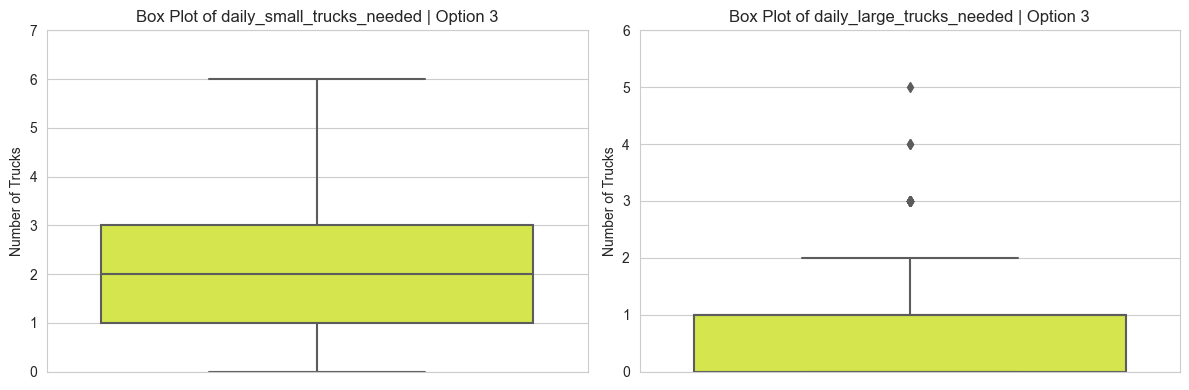

In [35]:
# let's visualise the outliers for Option 3

# columns to plot
columns_to_plot = ['daily_small_trucks_needed', 'daily_large_trucks_needed']

# figure & a grid of subplots
fig, axes = plt.subplots(1, len(columns_to_plot), figsize=(12, 4))

# loop to create individual box plots for each column next to each other
for i, column in enumerate(columns_to_plot):
    sns.boxplot(y=groupby_date_agg_trucks_op_3[column], ax=axes[i], color='#E7FE34')
    axes[i].set_title(f'Box Plot of {column} | Option 3')
    axes[i].set_ylabel('Number of Trucks')

    # set y-limits for a closer scale
    axes[i].set_ylim(min(groupby_date_agg_trucks_op_3[column]), max(groupby_date_agg_trucks_op_3[column]) + 1)

plt.savefig('/images/data_visualisations/fig9_boxplots_option3.png')


plt.tight_layout()

plt.show()

## OPTION 3 | BOX PLOT OBSERVATIONS:

**Small Trucks:**

- Interquartile Range & Median: The IQR is 1 - 3 with a median of 2, suggesting that on most days, you would likely need between 1 - 3 small trucks, with a typical day requiring just 2 small trucks.
- Whiskers / Tail: The left whisker extends from 0 - 1, indicating that there are days when only 0 or 1 small truck may be sufficient. The right whisker stretches from 3 - 6, showing that there are also days when up to 6 small trucks might be needed.
- Outliers: The absence of outliers suggests that the demand for small trucks is fairly consistent, without any extreme values that would significantly deviate from the rest of the data.

**Large Trucks:**

- Interquartile Range & Median: The IQR is 0 - 1, indicating that most days will require between 0 - 1 large trucks. The median seems to be 1, reinforcing that a typical day would likely need 1 large truck.
- Whiskers / Tail: The absence of a left whisker indicates that the demand for 0 large trucks is so common it's not considered an outlier. The right whisker extends from 1 - 2, suggesting that there are days when up to 2 large trucks may be needed.
- Outliers: The outliers at 3 - 5 indicate rare days when an unusually high number of large trucks would be needed. These should be considered in contingency planning but are not representative of daily demand.

**CONCLUSION:**

- Given the specific focus of Option 3 on maximising the efficiency of small trucks for deliveries within Greater London, the boxplot data offers valuable insights for operational planning. According to the data, a typical day would require 2 small trucks and possibly 1 large truck. With an IQR of 1 - 3 for small trucks and 0 - 1 for large trucks, this suggests that most operational needs can be met with a relatively small and consistent fleet.

- The absence of outliers in the small truck data indicates a stable and predictable demand, aligning well with the aim to optimise asset utilization. This consistent demand makes it easier to plan for multiple trips within Greater London, as per the one-hour round-trip time and one-hour loading time per delivery. This could indeed allow each small truck to reload approximately three times per working day, thus potentially reducing the number of small trucks needed by 2, as mentioned in the option description. For large trucks, while outliers at 3 - 5 suggest rare peak demand days, these are not typical and can be planned for through contingency measures.

- In conclusion, Option 3 appears to be a cost-effective and efficient strategy, particularly for operations focused within Greater London. It not only allows for asset maximsation but also offers the potential for significant cost savings by reducing the small truck fleet. Therefore, Option 3 stands as a strong choice for Mr. Haulage.

## OPTION 4 | COMBINES OPTION 1 & 3 ABOVE
Combining both opting for large trucks to delivery 3 small boxes to the same region per day AND small trucks in Greater London doing 3 trips per day

In [36]:
# let's copy the estimated daily demand to calculate OPTION 4
daily_demand_op_4 = estimated_daily_demand.copy()

In [37]:
# initialise list to store aggregated records
aggregated_data_daily_op_4 = []

# loop through each unique combination of delivery_region & order_date
for (region, date) in daily_demand_op_4.groupby(['delivery_region', 'order_date']).groups.keys():
    region_date_data_op_4 = daily_demand_op_4[(daily_demand_op_4['delivery_region'] == region) & (daily_demand_op_4['order_date'] == date)]

    # Initialise counters
    daily_small_trucks_op_4 = 0
    daily_large_trucks_op_4 = 0

        # calculate the number of small trucks
    if 'small' in region_date_data_op_4['box_type'].values:
        daily_small_box_count_op_4 = region_date_data_op_4.loc[region_date_data_op_4['box_type'] == 'small', 'box_count'].values[0]

        # Greater London: each small truck can make 3 deliveries each day
        if region == 'greater_london':
            daily_small_trucks_op_4 += daily_small_box_count_op_4 // 3
            remaining_small_boxes_op_4 = daily_small_box_count_op_4 % 3
        else:
            # convert sets of 4 small boxes to a large truck for other regions
            daily_large_trucks_op_4 += daily_small_box_count_op_4 // 4
            remaining_small_boxes_op_4 = daily_small_box_count_op_4 % 4

        # if there are 3 remaining small boxes, use a large truck
        if remaining_small_boxes_op_4 == 3:
            daily_large_trucks_op_4 += 1
        # if there are 2 remaining small boxes, use two small trucks
        elif remaining_small_boxes_op_4 == 2:
            daily_small_trucks_op_4 += 2
        # if there is 1 remaining small box, use a small truck
        elif remaining_small_boxes_op_4 == 1:
            daily_small_trucks_op_4 += 1


    # calculate the number of large trucks
    if 'large' in region_date_data_op_4['box_type'].values:
        daily_large_box_count_op_4 = region_date_data_op_4.loc[region_date_data_op_4['box_type'] == 'large', 'box_count'].values[0]
        daily_large_trucks_op_4 += daily_large_box_count_op_4

    # append to initialised list
    aggregated_data_daily_op_4.append([date, region, daily_small_trucks_op_4, daily_large_trucks_op_4])

# convert list to dataframe
aggregated_df_daily_op_4 = pd.DataFrame(aggregated_data_daily_op_4, columns=['order_date', 'delivery_region', 'daily_small_trucks_needed', 'daily_large_trucks_needed']).sort_values(by='order_date', ascending=True)

aggregated_df_daily_op_4

,order_date,delivery_region,daily_small_trucks_needed,daily_large_trucks_needed
837,2022-03-01,south_west,1,1
493,2022-03-01,south_east,1,0
742,2022-03-01,south_wales,1,0
122,2022-03-01,greater_london,0,1
1004,2022-03-01,west_midlands,1,0
...,...,...,...,...
121,2023-03-29,east_midlands,1,0
741,2023-03-30,south_east,0,1
393,2023-03-30,greater_london,2,0
1003,2023-03-31,south_west,1,0


In [38]:
# let's group by date and aggregate the count of trucks
groupby_date_agg_trucks_op_4 = aggregated_df_daily_op_4.groupby('order_date').agg({
    'daily_small_trucks_needed': 'sum',
    'daily_large_trucks_needed': 'sum'
}).reset_index()

groupby_date_agg_trucks_op_4

,order_date,daily_small_trucks_needed,daily_large_trucks_needed
0,2022-03-01,4,2
1,2022-03-02,3,1
2,2022-03-03,3,1
3,2022-03-04,4,1
4,2022-03-05,2,2
...,...,...,...
391,2023-03-27,1,1
392,2023-03-28,4,0
393,2023-03-29,2,0
394,2023-03-30,2,1


In [39]:
# now, to see the maximum, we'd need to service the contract efficiently
max_small_trucks_op_4 = groupby_date_agg_trucks_op_4['daily_small_trucks_needed'].max()
max_large_trucks_op_4 = groupby_date_agg_trucks_op_4['daily_large_trucks_needed'].max()

cost_of_fleet_expenditure_op_4 = (max_large_trucks_op_4 * large_truck_purchase_cost) + (max_small_trucks_op_4 * small_truck_purchase_cost)

print(f"The total number of Small Trucks to purchase based on the historical dataset provided is: {max_small_trucks_op_4}.")
print(f"--------------------------------------------------------")
print(f"The total number of Large Trucks to purchase based on the historical dataset provided is: {max_large_trucks_op_4}.")
print(f"--------------------------------------------------------")
print(f"The total expenditure to purchase this sized fleet would be : £{cost_of_fleet_expenditure_op_4:,.2f}.")
print(f"--------------------------------------------------------")
print(f"£{cost_of_fleet_expenditure_op_4:,.2f} is {cost_of_fleet_expenditure_op_4 / total_yearly_income * 100:,.2f}% of the yearly income.")
print(f"--------------------------------------------------------")

The total number of Small Trucks to purchase based on the historical dataset provided is: 8.
--------------------------------------------------------
The total number of Large Trucks to purchase based on the historical dataset provided is: 5.
--------------------------------------------------------
The total expenditure to purchase this sized fleet would be : £41,000.00.
--------------------------------------------------------
£41,000.00 is 70.59% of the yearly income.
--------------------------------------------------------


### OBSERVATIONS:
- Let's look for outliers in this data that could be skewing the results

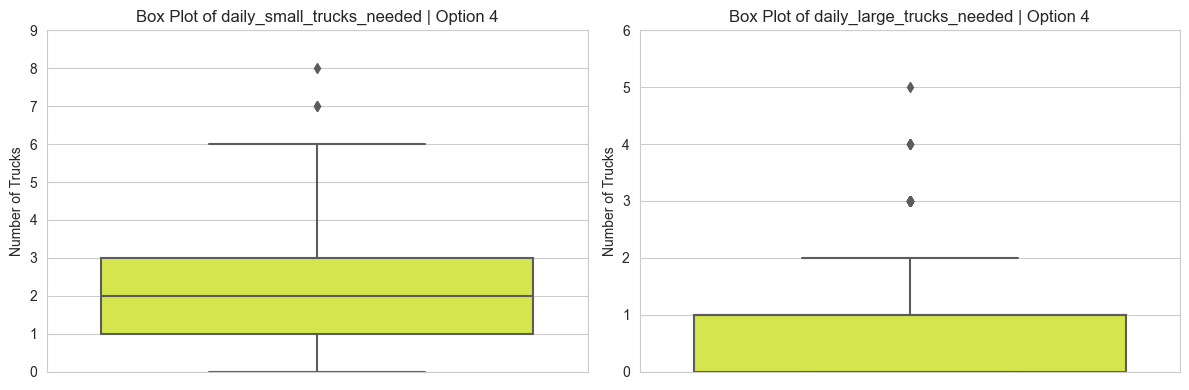

In [40]:
# let's visualise the outliers for Option 4

# columns to plot
columns_to_plot = ['daily_small_trucks_needed', 'daily_large_trucks_needed']

# figure & a grid of subplots
fig, axes = plt.subplots(1, len(columns_to_plot), figsize=(12, 4))

# loop to create individual box plots for each column next to each other
for i, column in enumerate(columns_to_plot):
    sns.boxplot(y=groupby_date_agg_trucks_op_4[column], ax=axes[i], color='#E7FE34')
    axes[i].set_title(f'Box Plot of {column} | Option 4')
    axes[i].set_ylabel('Number of Trucks')

    # set y-limits for a closer scale
    axes[i].set_ylim(min(groupby_date_agg_trucks_op_4[column]), max(groupby_date_agg_trucks_op_4[column]) + 1)

plt.savefig('/images/data_visualisations/fig10_boxplots_option4.png')

plt.tight_layout()

plt.show()

## BOX PLOT OBSERVATIONS:

**Small Trucks:**

- Interquartile Range & Median: The IQR for small trucks is 1 - 3, with a median of 2. This suggests that on most days, Mr. Haulage would need between 1 - 3 small trucks, with a typical day requiring just 2 small trucks.
- Whiskers / Tail: The left whisker of 0 - 1 indicates that there are days when no small trucks or just one may be sufficient. The right whisker ranging from 3 - 6 suggests that there are also days when up to 6 small trucks might be needed.
- Outliers: Outliers at 7 - 8 indicate rare occasions when an unusually high number of small trucks would be required. These should be considered in contingency planning but are not indicative of typical daily needs.

**Large Trucks:**

- Interquartile Range & Median: The IQR for large trucks is 0 - 1, suggesting that most days will likely require between 0 - 1 large trucks. The median appears to be 1, indicating a typical day would most likely need 1 large truck.
- Whiskers / Tail: The absence of a left whisker suggests that 0 large trucks are often sufficient, confirming that these lower values are very common. The right whisker extends from 1 - 2, suggesting some days when 1 - 2 large trucks might be needed.
- Outliers: Outliers at 3 - 5 indicate rare situations when a high number of large trucks would be required. These should be considered in contingency planning but are not indicative of typical daily needs.

**CONCLUSION:**
- Option 4 presents a hybrid strategy that aims to blend the strengths of both Options 1 and 3. According to the boxplot data, a typical day under this option would require 2 small trucks and likely 1 large truck. The IQR for both small and large trucks (1 - 3 and 0 - 1, respectively) aligns well with this, suggesting that most operational needs can be met with a relatively consistent and small fleet.
- The consistency in demand for small trucks, as indicated by the absence of extreme outliers, allows for effective planning of multiple trips within Greater London, just as in Option 3. For large trucks, the outliers at 3 - 5, although rare, will require contingency planning. However, the overall predictability in large truck demand makes the operational planning more straightforward, much like in Option 1.
- In summary, Option 4 appears to be a robust and flexible strategy, marrying the benefits of Options 1 and 3. It enables Mr. Haulage to capitalize on the flexibility and efficiency of using large trucks for multiple small box deliveries while also optimising small truck use for Greater London deliveries. This could potentially offer the best of both worlds, making it a strong choice for a balanced, cost-effective, and growth-oriented operational plan.

# FINAL EXPLORATORY DATA ANALYSIS CONCLUSIONS:

**Immediate Needs:**
Based on the historical data provided, our analysis indicates that your operation would initially require 8 small trucks and 5 large trucks to meet the current demand. Based on the historial data provided only, & according to the boxplot data from the 4 options I have presented above, the immediate requirement for a typical day would range between 2-3 small trucks and 1-2 large trucks. However, peak days could require up to 6 small trucks and 5 large trucks.

**Increasing Operational Efficiency:**
 - Multiple Journeys for Small trucks: If we consider the multiple trips that small trucks could perform within Greater London, as outlined in Option 3 and incorporated into Option 4, the peak requirement for small trucks could potentially be less than 6. This is because each small truck could be reloaded approximately three times per working day for deliveries within Greater London, significantly increasing asset utilisation and potentially reducing the number of small trucks needed.  Our analysis suggests that if a small truck could undertake 3 trips per day instead of 1, the total number of small trucks required could be significantly reduced. This not only decreases initial investment but also reduces ongoing operational costs such as maintenance, fuel, and labour.
 - Invest in Logistics Software: Effective route planning and real-time tracking can significantly improve the utilisation rate of each vehicle in the fleet. We recommend considering an investment in advanced logistics and planning software to maximise the efficiency of each trip.

**Long-Term Planning:**
Fleet Resale Value: As part of a comprehensive cost-benefit analysis, we recommend investigating the potential revenue from selling the current fleet. This could offset some of the costs of upgrading to a more efficient and modern fleet.
Expand Data Collection: The more data we have, the more accurate and tailored our recommendations can be. Future considerations like seasonal demand fluctuations or growth projections could be more accurately modelled with additional data.

I will now conduct an initial cost analysis to provide a more detailed view of the potential investment and savings.
### Let's create the dataframe to save & use for our cost analysis by merging the dataframes back together:

In [41]:
# merge the dataframes
merged_df = pd.merge(estimated_daily_demand, aggregated_df_daily_op_4, on=['order_date', 'delivery_region'], how='left')

# sort the data
merged_df.sort_values(['order_date', 'delivery_region', 'box_type'], inplace=True)

# initialise new columns
merged_df['new_daily_small_trucks_needed'] = 0
merged_df['new_daily_large_trucks_needed'] = 0

# conditions as to where data is copied to
for index, row in merged_df.iterrows():
    # For 'small' box_type
    if row['box_type'] == 'small':
        # Special condition for Greater London with 4 small boxes
        if row['delivery_region'] == 'greater_london' and row['box_count'] == 4:
            merged_df.at[index, 'new_daily_large_trucks_needed'] = 1
        # Special condition for Greater London with 3 small boxes
        elif row['delivery_region'] == 'greater_london' and row['box_count'] in [1,2,3]:
            merged_df.at[index, 'new_daily_small_trucks_needed'] = 1
        # Special condition for Greater London with 5 small boxes
        elif row['delivery_region'] == 'greater_london' and row['box_count'] == 5:
            merged_df.at[index, 'new_daily_large_trucks_needed'] = 1
            merged_df.at[index, 'new_daily_small_trucks_needed'] = 1
        # Handle box_count 1 or 2
        elif row['box_count'] in [1, 2]:
            merged_df.at[index, 'new_daily_small_trucks_needed'] = row['daily_small_trucks_needed']
        # Handle box_count 3 or 4
        elif row['box_count'] in [3, 4]:
            merged_df.at[index, 'new_daily_large_trucks_needed'] = row['daily_large_trucks_needed']
        # Handle box_count greater than 4
        elif row['box_count'] > 4:
            merged_df.at[index, 'new_daily_small_trucks_needed'] = row['daily_small_trucks_needed']
            merged_df.at[index, 'new_daily_large_trucks_needed'] = row['daily_large_trucks_needed']
    # For 'large' box_type
    elif row['box_type'] == 'large' and row['box_count'] > 0:
        # Check if there are 'small' boxes with counts of 3 or 4 for the same day and delivery region
        same_day_region = merged_df[
            (merged_df['order_date'] == row['order_date']) &
            (merged_df['delivery_region'] == row['delivery_region'])
        ]
        small_boxes_3_or_4 = same_day_region[
            (same_day_region['box_type'] == 'small') &
            (same_day_region['box_count'].isin([3, 4]))
        ]

        # If there are no 'small' boxes with counts of 3 or 4, then increment the large trucks needed
        if small_boxes_3_or_4.empty:
            merged_df.at[index, 'new_daily_large_trucks_needed'] = row['daily_large_trucks_needed']


# drop columns after creating new ones
merged_df.drop(['daily_small_trucks_needed', 'daily_large_trucks_needed'], axis=1, inplace=True)

# rename them back
merged_df.rename(columns={
    'new_daily_small_trucks_needed': 'daily_small_trucks_needed',
    'new_daily_large_trucks_needed': 'daily_large_trucks_needed'
}, inplace=True)

merged_df

,order_date,delivery_region,box_type,box_count,daily_small_trucks_needed,daily_large_trucks_needed
0,2022-03-01,greater_london,large,1,0,1
1,2022-03-01,south_east,small,1,1,0
2,2022-03-01,south_wales,small,1,1,0
3,2022-03-01,south_west,large,1,0,1
4,2022-03-01,south_west,small,1,1,0
...,...,...,...,...,...,...
1179,2023-03-29,south_east,small,1,1,0
1180,2023-03-30,greater_london,small,2,1,0
1181,2023-03-30,south_east,large,1,0,1
1182,2023-03-31,south_west,small,1,1,0


NB: Some of the above conditions are hard-coded which is less than ideal. If I had more time, I'd practiced Test-Driven Development to ensure that the correct data was being copied or errors thrown & I would not have hard-coded any of the conditions, they should be * or %, but I ran out of time to figure it all out.

### I'm going to add in the financial columns in the cost analysis notebook, in hindsight, I did it too early before.
### Let's save this to .csv for the cost analysis:

In [42]:
# let's save the final merged_dataset to a new csv file for the cost analysis

merged_df.to_csv('/datasets/mr_haulage_merged_df_for_cost_analysis.csv', index=False, sep=',')

print(f"The dataframe 'merged_df' has been saved for analysis as 'mr_haulage_merged_df_for_cost_analysis.csv'")

The dataframe 'merged_df' has been saved for analysis as 'mr_haulage_merged_df_for_cost_analysis.csv'
